In [113]:
# !pip install torch
# !pip install torchvision

In [114]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from tqdm import tqdm

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [115]:
# FC VAE Architecture
class FCVAE(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(FCVAE, self).__init__()
        # Encoder
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim)
        # Decoder
        self.fc2 = nn.Linear(latent_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, input_dim)

    def encode(self, x):
        h1 = torch.relu(self.fc1(x))
        return self.fc_mu(h1), self.fc_logvar(h1)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h2 = torch.relu(self.fc2(z))
        return torch.sigmoid(self.fc3(h2)).view(-1, 3, 32, 32)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

In [116]:
# Conv VAE Architecture
class ConvVAE(nn.Module):
    def __init__(self, latent_dim):
        super(ConvVAE, self).__init__()
        # Encoder
        self.conv1 = nn.Conv2d(3, 32, 4, stride=2, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 4, stride=2, padding=1)
        self.conv3 = nn.Conv2d(64, 128, 4, stride=2, padding=1)
        self.conv4 = nn.Conv2d(128, 256, 4, stride=2, padding=1)

        self.conv_mu = nn.Conv2d(256, latent_dim, kernel_size=2)
        self.conv_logvar = nn.Conv2d(256, latent_dim, kernel_size=2)
        
        # Decoder
        self.deconv1 = nn.ConvTranspose2d(latent_dim, 256, 2, stride=1)
        self.deconv2 = nn.ConvTranspose2d(256, 128, 4, stride=2, padding=1)
        self.deconv3 = nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1)
        self.deconv4 = nn.ConvTranspose2d(64, 32, 4, stride=2, padding=1)
        self.deconv5 = nn.ConvTranspose2d(32, 3, 4, stride=2, padding=1)

        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def encode(self, x):    
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.relu(self.conv3(x))
        x = self.relu(self.conv4(x))

        mu = self.conv_mu(x).squeeze(-1).squeeze(-1)
        logvar = self.conv_logvar(x).squeeze(-1).squeeze(-1)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        x = z.unsqueeze(-1).unsqueeze(-1)
        x = self.relu(self.deconv1(x))
        x = self.relu(self.deconv2(x))
        x = self.relu(self.deconv3(x))
        x = self.relu(self.deconv4(x))
        x = self.sigmoid(self.deconv5(x))
        return x

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar


In [117]:
# Loss function
def loss_function_cvae(recon_x, x, mu, logvar):
    MSE = nn.functional.mse_loss(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return MSE + KLD, MSE, KLD

def loss_function_fcvae(recon_x, x, mu, logvar):    
    BCE = nn.functional.binary_cross_entropy(recon_x.view(-1, 3072), x.view(-1, 3072), reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD, BCE, KLD

In [118]:
# Training the VAE
def train(model, train_loader, optimizer, epoch, num_epochs, model_name, device):
    model.train()
    train_loss_total = 0
    recon_loss_total = 0
    kld_loss_total = 0
    with tqdm(train_loader, unit='batch', desc=f'Epoch {epoch}', colour='green') as tepoch:
        for batch_idx, (data, _) in enumerate(tepoch):
            if model_name == 'cvae':
                data = data.view(data.size(0), 3, 32, 32).to(device)
            elif model_name == 'fcvae':
                data = data.view(data.size(0), -1).to(device)   
            optimizer.zero_grad()
            recon_batch, mu, logvar = model(data)
            if model_name == 'cvae':
                loss_function = loss_function_cvae
            elif model_name == 'fcvae':
                loss_function = loss_function_fcvae
            total_loss, recon_loss, kld_loss = loss_function(recon_batch, data, mu, logvar)
            total_loss.backward()
            train_loss_total += total_loss.item()
            recon_loss_total += recon_loss.item()
            kld_loss_total += kld_loss.item()
            optimizer.step()
            tepoch.set_postfix(
                train_loss=train_loss_total / len(train_loader.dataset),
                recon_loss=recon_loss_total / len(train_loader.dataset),
                kld_loss=kld_loss_total / len(train_loader.dataset)
            )
    print(f'Epoch {epoch}/{num_epochs} train loss: {train_loss_total / len(train_loader.dataset)} mse loss: {recon_loss_total / len(train_loader.dataset)} kld loss: {kld_loss_total / len(train_loader.dataset)}')

In [119]:
# Load MNIST dataset and run the training
transform_cvae = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
])

train_dataset_cvae = datasets.CIFAR10('./data/cvae', train=True, download=True, transform=transform_cvae)
train_loader_cvae = torch.utils.data.DataLoader(train_dataset_cvae, batch_size=128, shuffle=True)

cvae = ConvVAE(latent_dim=128)
optimizer_cvae = optim.Adam(cvae.parameters(), lr=1e-3)

transform_fcvae = transforms.Compose([
    transforms.ToTensor()
])

train_dataset_fcvae = datasets.CIFAR10('./data/fcvae', train=True, download=True, transform=transform_fcvae)
train_loader_fcvae = torch.utils.data.DataLoader(train_dataset_fcvae, batch_size=128, shuffle=True)

fcvae = FCVAE(input_dim=3072, hidden_dim=400, latent_dim=128)
optimizer_fcvae = optim.Adam(fcvae.parameters(), lr=1e-3)

num_epochs = 5

print('--------------------------------------------------------------------------------')

for epoch in range(1, num_epochs + 1):
    train(cvae, train_loader_cvae, optimizer_cvae, epoch, num_epochs, 'cvae', device)

print('--------------------------------------------------------------------------------')

for epoch in range(1, num_epochs + 1):
    train(fcvae, train_loader_fcvae, optimizer_fcvae, epoch, num_epochs, 'fcvae', device)

Files already downloaded and verified
Files already downloaded and verified
--------------------------------------------------------------------------------


Epoch 1: 100%|██████████| 391/391 [00:57<00:00,  6.83batch/s, kld_loss=10.9, recon_loss=682, train_loss=693]    


Epoch 1/5 train loss: 692.6371675 mse loss: 681.76999 kld loss: 10.867177743618488


Epoch 2: 100%|██████████| 391/391 [00:47<00:00,  8.17batch/s, kld_loss=18, recon_loss=578, train_loss=596]    


Epoch 2/5 train loss: 595.949594765625 mse loss: 577.981664453125 kld loss: 17.96792930419922


Epoch 3: 100%|██████████| 391/391 [00:51<00:00,  7.52batch/s, kld_loss=20.5, recon_loss=547, train_loss=568]  


Epoch 3/5 train loss: 567.789069140625 mse loss: 547.2586271875 kld loss: 20.53044064453125


Epoch 4: 100%|██████████| 391/391 [00:52<00:00,  7.51batch/s, kld_loss=22, recon_loss=534, train_loss=556]    


Epoch 4/5 train loss: 555.8455359375 mse loss: 533.88216515625 kld loss: 21.963371345214842


Epoch 5: 100%|██████████| 391/391 [00:51<00:00,  7.52batch/s, kld_loss=22.9, recon_loss=527, train_loss=550]  


Epoch 5/5 train loss: 550.1005775 mse loss: 527.1698609375 kld loss: 22.93071837402344
--------------------------------------------------------------------------------


Epoch 1: 100%|██████████| 391/391 [00:16<00:00, 23.14batch/s, kld_loss=0.0898, recon_loss=0.0054, train_loss=0.0952] 


Epoch 1/5 train loss: 0.09522550608634948 mse loss: 0.005399378923177719 kld loss: 0.08982612533211708


Epoch 2: 100%|██████████| 391/391 [00:17<00:00, 22.89batch/s, kld_loss=9.26e-8, recon_loss=0.00539, train_loss=0.00539] 


Epoch 2/5 train loss: 0.005393248802423477 mse loss: 0.0053931561815738676 kld loss: 9.2620849609375e-08


Epoch 3: 100%|██████████| 391/391 [00:20<00:00, 19.10batch/s, kld_loss=0, recon_loss=0.00539, train_loss=0.00539] 


Epoch 3/5 train loss: 0.005391940311193466 mse loss: 0.005391940311193466 kld loss: 0.0


Epoch 4: 100%|██████████| 391/391 [00:26<00:00, 14.67batch/s, kld_loss=0, recon_loss=0.00539, train_loss=0.00539] 


Epoch 4/5 train loss: 0.005391425038576126 mse loss: 0.005391425038576126 kld loss: 0.0


Epoch 5: 100%|██████████| 391/391 [00:31<00:00, 12.51batch/s, kld_loss=0, recon_loss=0.00539, train_loss=0.00539] 

Epoch 5/5 train loss: 0.005390808145999909 mse loss: 0.005390808145999909 kld loss: 0.0


In [120]:
import matplotlib.pyplot as plt

# Function to generate and display new images
def generate_images(model, num_images, latent_dim):
    model.eval()  # Set model to evaluation mode
    with torch.no_grad():  # Turn off gradients for generation
        # Sample random points from the latent space (standard normal distribution)
        z = torch.randn(num_images, latent_dim)
        # Decode these points to generate images
        generated_images = []
        for i in tqdm(range(num_images), desc='Generating images', unit='image', colour='blue'):
            generated_image = model.decode(z[i:i+1]).cpu()
            generated_images.append(generated_image)
    # Convert the generated images to a single tensor
    generated_images = torch.cat(generated_images, dim=0)

    # Plot the generated images
    fig, axs = plt.subplots(1, num_images, figsize=(num_images, 1.5))
    for i in range(num_images):
        axs[i].imshow(generated_images[i].numpy().transpose(1, 2, 0))
        axs[i].axis('off')
    plt.show()

Images from FC VAE


Generating images: 100%|██████████| 5/5 [00:00<00:00, 902.43image/s]

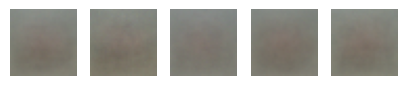

Images from Conv VAE


Generating images: 100%|██████████| 5/5 [00:00<00:00, 129.32image/s]


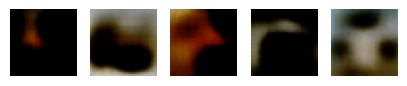

In [124]:
# Assuming you have already trained the model (vae) and it has a latent dimension of 128
print('Images from FC VAE')
generate_images(fcvae, num_images=5, latent_dim=128)

print('Images from Conv VAE')
generate_images(cvae, num_images=5, latent_dim=128)